# Constants and Setup

In [1]:
import os

# whether to commit and push to git after each optimization. intended for long runs
PUSH_TO_GIT = True

# parent output directory
EXPERIMENTS_DIR = os.path.join("experiments", "bayes_opt_2")

Bayesian Optimization and train parameters

In [2]:
MAX_ITERATIONS = 10     # max iterations for bayesian optimization

NUM_TRAIN_EPOCHS = 50   # total number of epochs tot rain for
EARLY_STOP = 6          # give up training if validation accuracy doesn't improve after this many epochs

Optimizer to use. Choose by commenting. Supposedly by Wilson et al. 2018, SGD generalizes better.

In [3]:
import torch.optim as optim

OPTIMIZERS = (
    optim.Adam,
    optim.SGD,
)

Models to test for BO. All in the list will be optimized.

In [4]:
from torchvision import models as tvm
import pretrainedmodels as ptm

# The models we will test
MODELS = (
#     ptm.alexnet, # gets maximum recursion limit exceeded exceptions
#     se_resnext101_32x4d, # input size doesn't work
    ptm.nasnetamobile,
    ptm.se_resnet50,
    ptm.se_resnet101,
    ptm.inceptionresnetv2,
    ptm.inceptionv4,
    tvm.resnet101,
    tvm.resnet152,
    ptm.senet154,
    ptm.pnasnet5large,  # CUDA out of memory errors. only works batch_size <= 12
    ptm.polynet,  # CUDA out of memory. only works batch_size <= 16
    ptm.nasnetalarge, # only works batch_size <= 12
    ptm.vgg16,
    ptm.vgg19,
)

REQUIRES_SMALL_BATCH = {ptm.pnasnet5large, ptm.polynet, ptm.nasnetalarge}

Setup: Make sure Jupyter shows all output

In [5]:
# show more than one output in cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# display full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

# plot charts in our notebook
%matplotlib inline

import subprocess  # for command line control, git
import sys
sys.setrecursionlimit(3000) # for some reason AlexNet requires more recursive depth

## Helper Functions

In [6]:
import src.utils as utils
from src.trainable import Trainable
import torch


CRITERION = torch.nn.CrossEntropyLoss() # we'll always use CE for the loss function
 

def train(params, is_best=False):
    """
    Set up a trainable and train it using the given parameters.
    """
    global iteration
    iteration += 1
    print('Iteration', iteration if not is_best else "BEST", end=', ')
    print(params_to_meta_dict(params))  # print the input
    batch_size, lr_factor, optim_params = parse_train_params(params)
    
    # make an output directory using the dataset name, model name, and BO iteration
    outdir = make_outdir_name(
        data_dir, 
        utils.get_model_name(chosen_model), 
        chosen_optimizer.__name__,
        str(iteration) if not is_best else "BEST",
        prepend=EXPERIMENTS_DIR
    )
    
    # make our data loaders based on the image size
    image_size = utils.determine_image_size(utils.get_model_name(chosen_model))
    # get_train_val_dataloaders() makes a stratified random partitions of a train and validation set
    dataloaders = utils.get_train_val_dataloaders(
        datadir=data_dir,
        val_proportion=0.15,
        image_size=image_size, 
        batch_size=batch_size
    )
    # build our model
    model = build_model(chosen_model)
    utils.fit_model_last_to_dataset(model, dataloaders['train'].dataset)
    # build the optimizer
    optimizer = chosen_optimizer(model.parameters(), *optim_params)
    # "ReduceOnPlateau" is "dev-decay" as recommended by Wilson et al. 2018 
    # "The Marginal Value of Adaptive Gradient Methods"
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max', 
        factor=lr_factor, 
        patience=1
    )
    
    trainable = Trainable(dataloaders, model, CRITERION, optimizer, lr_scheduler, outdir=outdir)
    early_stop = None if is_best else EARLY_STOP  # only early stop if BO. else if training our best, do the full thing
    trainable.train(num_epochs=NUM_TRAIN_EPOCHS, early_stop_limit=early_stop, verbose=False)

    return trainable


def parse_train_params(params):
    """
    Parses train parameters by converting batch size to an int, and the betas to a tuple for Adam.
    """
    batch_size, lr_factor, optim_params = int(params[0]), params[1], params[2:]
    if chosen_optimizer is torch.optim.Adam:  # turn b1 and b2 into a tuple
        # NOTE the below indexes are based on purely ADAM_DOMAin
        optim_params = (optim_params[0], tuple(optim_params[1:3]), optim_params[3])
#         print('OPTIM_PARAMS', optim_params)
    return batch_size, lr_factor, optim_params

    
def build_model(model_fn):
    """
    Build a pretrained model class from a model function. Passes 
    in the appropriate pretrained arg based on the model function's 
    parent module.
    """
    if 'pretrainedmodels' in model_fn.__module__:
        model = model_fn(num_classes=1000, pretrained='imagenet')
    else:
        model = model_fn(pretrained=True)
    return model


def make_key_from_params(params):
    """
    Makes a unique key (as a tuple) from a given list of parameters.
    For storing associated Trainable objects.
    
    """
    return tuple(round(param, 10) for param in params)


def make_outdir_name(data_dir, *append, prepend=""):
    """
    Make the output directory name based on dataset, model name, and any extra info.
    """
    dataset_name = os.path.basename(data_dir)
    return os.path.join(prepend, dataset_name, *append) 


In [7]:
from IPython.display import Javascript

script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
def save_notebook():
    """Save the Jupyter notebook"""
    Javascript(script)

def push_to_git(message="Commit"):
    save_notebook()
    try:
        _ = subprocess.check_call(['git', 'add', '-u'])
        _ = subprocess.check_call(['git', 'add', EXPERIMENTS_DIR])
        _ = subprocess.check_call(['git', 'commit', '-am', message])
        _ = subprocess.check_call(['git', 'push'])
    except Error as e:
        print("ERROR: Could not push to git.", e)

# Bayesian Optimization

## Define the Problem

### Domain

In [8]:
SMALL_BATCH = (1, 4, 8, 12)
MEDIUM_BATCH = (16, 24, 32, 48, 64)

BASE_DOMAIN = [
#     {'name': 'batch_size', 'type': 'discrete', 'domain': (1, 4, 8, 12)},  # DEBUG for GPUs with insufficient memory
    {'name': 'batch_size', 'type': 'discrete', 'domain': MEDIUM_BATCH},
    {'name': 'lr_decay', 'type': 'continuous', 'domain': (0.03, 0.3)},
]

ADAM_DOMAIN = BASE_DOMAIN + [
    {'name': 'adam_lr', 'type': 'continuous', 'domain': (0.001, 0.1)},
    {'name': 'adam_beta1', 'type': 'continuous', 'domain': (0.8, .99)},
    {'name': 'adam_beta2', 'type': 'continuous', 'domain': (0.95, .9999)},
    {'name': 'adam_wtdecay', 'type': 'continuous', 'domain': (0, 1)}
]
# TODO: have to figure out how to set a starting default
# default_input = [32, 0.001, 0.9, 0.999, 0] 

SGD_DOMAIN = BASE_DOMAIN + [
    {'name': 'lr', 'type': 'continuous', 'domain': (0.001, 0.1)},
    {'name': 'momentum', 'type': 'continuous', 'domain': (0.5, .99)},
    {'name': 'weight_decay', 'type': 'continuous', 'domain': (0, 1)}
]

### Function to optimize

In [9]:
def f(x):
    """ Value function to maximize for bayesian optimization """
    params = x.flatten()
#     print('PARAMS', params)
    
    trainable = train(params)
    val_acc = trainable.best_val_accuracy
    
    return val_acc

## Do BO on all models on both datasets.

In [10]:
from GPyOpt.methods import BayesianOptimization
from predict import create_predictions
from metrics import create_all_metrics

### BO helper functions

In [11]:
def reset_globals(datadir):
    """
    Reset the iteration and set the data directory
    """
    global iteration  # keep track of our optimization iterations for directory output
    iteration = 0   # but reset to 0 each train run
    global data_dir
    data_dir = datadir
    

def get_domain():
    """
    Get the domain parameters given the chosen optimizer
    """
    domain = ADAM_DOMAIN if chosen_optimizer is torch.optim.Adam else SGD_DOMAIN
    # some models are too big to fit on our NVIDIA Quadro P5000 GPU. if the
    # chosen model is on eof these, decrease the batch size
    if chosen_model in REQUIRES_SMALL_BATCH:
        domain[0]['domain'] = SMALL_BATCH  # domain[0] is batch_size
        
    return domain
    
def perform_bayesian_optimization():
    """
    Construct the problem and run the optimization.
    """
    domain = get_domain()
    problem = BayesianOptimization(
        f=f,
        domain=domain,
        maximize=True
    )
    problem.run_optimization(max_iter=MAX_ITERATIONS)
    return problem

def plot_bo_results(problem):
    """
    Graph the acquisition function and convergence
    """
    print('Best params:', problem.x_opt)
    problem.plot_acquisition()
    problem.plot_convergence()
    
    
def params_to_meta_dict(params):
    """
    Takes a list and returns a dictionary of named parameters based on domain index
    """
    domain = get_domain()
    meta = { d['name']: float(params[i]) for i, d in enumerate(domain)}
    return meta


def generate_test_metrics(trainable):
    """
    Create an itemized predictions file and metrics for the test set.
    """
    predictions_file = create_predictions(
        outdir=trainable.outdir,
        subset='test',
        data_dir=data_dir,
        model=best_trainable.model
    )
    create_all_metrics(predictions_file, trainable.outdir, 'test')

### Main loop

nasnetamobile Adam data/die_vs_all_tt
Iteration 1, {'batch_size': 48.0, 'lr_decay': 0.13606525397353542, 'adam_lr': 0.06531645144718246, 'adam_beta1': 0.8247192391926832, 'adam_beta2': 0.9700064907438666, 'adam_wtdecay': 0.8645788394673907}


Training stopped early at 11 epochs.
Best validation accuracy: 0.8944; Associated train accuracy: 0.9126
Iteration 2, {'batch_size': 16.0, 'lr_decay': 0.11741362142150999, 'adam_lr': 0.00521236652670609, 'adam_beta1': 0.8299715586062101, 'adam_beta2': 0.9995055749425191, 'adam_wtdecay': 0.18602089332358263}


Training stopped early at 21 epochs.
Best validation accuracy: 0.8222; Associated train accuracy: 0.9145
Iteration 3, {'batch_size': 16.0, 'lr_decay': 0.270681415967258, 'adam_lr': 0.06732472645562533, 'adam_beta1': 0.9474761502552853, 'adam_beta2': 0.9938210617577792, 'adam_wtdecay': 0.04335047879108145}


Training stopped early at 8 epochs.
Best validation accuracy: 0.5722; Associated train accuracy: 0.5501
Iteration 4, {'batch_size': 32.0, 'lr_decay': 0.052713297141560825, 'adam_lr': 0.08480504155927175, 'adam_beta1': 0.8932094423950917, 'adam_beta2': 0.9998927908209623, 'adam_wtdecay': 0.9416322057281397}


Training stopped early at 22 epochs.
Best validation accuracy: 0.8667; Associated train accuracy: 0.9106
Iteration 5, {'batch_size': 16.0, 'lr_decay': 0.04012164538015247, 'adam_lr': 0.08546931480059347, 'adam_beta1': 0.9104800666654932, 'adam_beta2': 0.976898118068372, 'adam_wtdecay': 0.5724790895195455}


Training stopped early at 8 epochs.
Best validation accuracy: 0.8722; Associated train accuracy: 0.8713
Iteration 6, {'batch_size': 48.0, 'lr_decay': 0.14040122590326942, 'adam_lr': 0.05960909542557366, 'adam_beta1': 0.8132875439325197, 'adam_beta2': 0.9702166691443174, 'adam_wtdecay': 0.8619438838107064}


Training stopped early at 8 epochs.
Best validation accuracy: 0.8944; Associated train accuracy: 0.8664
Iteration 7, {'batch_size': 48.0, 'lr_decay': 0.08171776884782313, 'adam_lr': 0.0691905368898733, 'adam_beta1': 0.836053328070918, 'adam_beta2': 0.9661867109001778, 'adam_wtdecay': 0.6814055239042898}


Training stopped early at 13 epochs.
Best validation accuracy: 0.8944; Associated train accuracy: 0.9204
Iteration 8, {'batch_size': 48.0, 'lr_decay': 0.2869770462256526, 'adam_lr': 0.015673634809715554, 'adam_beta1': 0.9307955348815274, 'adam_beta2': 0.9787357960964644, 'adam_wtdecay': 0.7250539502451895}


Training stopped early at 15 epochs.
Best validation accuracy: 0.8778; Associated train accuracy: 0.9224
Iteration 9, {'batch_size': 48.0, 'lr_decay': 0.22431914137355102, 'adam_lr': 0.1, 'adam_beta1': 0.8, 'adam_beta2': 0.9999, 'adam_wtdecay': 0.4109315606288394}


Training stopped early at 13 epochs.
Best validation accuracy: 0.9056; Associated train accuracy: 0.9037
Iteration 10, {'batch_size': 48.0, 'lr_decay': 0.032128306440695906, 'adam_lr': 0.1, 'adam_beta1': 0.9788055705415829, 'adam_beta2': 0.9999, 'adam_wtdecay': 0.3400202090181088}


Training stopped early at 16 epochs.
Best validation accuracy: 0.8944; Associated train accuracy: 0.9244
Iteration 11, {'batch_size': 48.0, 'lr_decay': 0.19577720990440586, 'adam_lr': 0.001, 'adam_beta1': 0.8, 'adam_beta2': 0.95, 'adam_wtdecay': 0.12418383119757687}


Training stopped early at 17 epochs.
Best validation accuracy: 0.8722; Associated train accuracy: 0.9077
Iteration 12, {'batch_size': 48.0, 'lr_decay': 0.3, 'adam_lr': 0.001, 'adam_beta1': 0.99, 'adam_beta2': 0.95, 'adam_wtdecay': 0.36571864704234663}


Training stopped early at 11 epochs.
Best validation accuracy: 0.7833; Associated train accuracy: 0.8271
Iteration 13, {'batch_size': 48.0, 'lr_decay': 0.03, 'adam_lr': 0.1, 'adam_beta1': 0.8, 'adam_beta2': 0.9999, 'adam_wtdecay': 0.3966377054320075}


Training stopped early at 15 epochs.
Best validation accuracy: 0.8722; Associated train accuracy: 0.9136
Iteration 14, {'batch_size': 16.0, 'lr_decay': 0.03, 'adam_lr': 0.001, 'adam_beta1': 0.8, 'adam_beta2': 0.9999, 'adam_wtdecay': 0.9214615520190845}


Training stopped early at 22 epochs.
Best validation accuracy: 0.6167; Associated train accuracy: 0.7043
Iteration 15, {'batch_size': 16.0, 'lr_decay': 0.03, 'adam_lr': 0.001, 'adam_beta1': 0.8, 'adam_beta2': 0.95, 'adam_wtdecay': 0.388589286408351}


Training stopped early at 14 epochs.
Best validation accuracy: 0.8389; Associated train accuracy: 0.8861
Best params: [48.          0.22431914  0.1         0.8         0.9999      0.41093156]


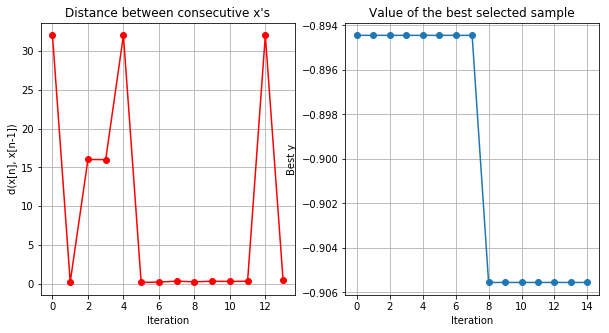

Best params: {'batch_size': 48.0, 'lr_decay': 0.22431914137355102, 'adam_lr': 0.1, 'adam_beta1': 0.8, 'adam_beta2': 0.9999, 'adam_wtdecay': 0.4109315606288394}
Iteration BEST, {'batch_size': 48.0, 'lr_decay': 0.22431914137355102, 'adam_lr': 0.1, 'adam_beta1': 0.8, 'adam_beta2': 0.9999, 'adam_wtdecay': 0.4109315606288394}


 /home/alwood/Development/Estrous-AI/predict.py:114: DeprecationWarning:Call to deprecated function (or staticmethod) get_datasets_and_loaders.
Predict:   0%|          | 0/214 [00:00<?, ?it/s]

Best validation accuracy: 0.9000; Associated train accuracy: 0.9244
Writing results to experiments/bayes_opt_2/die_vs_all_tt/nasnetamobile/Adam/BEST/test_predictions.csv


Predict: 100%|██████████| 214/214 [00:02<00:00, 79.06it/s]


7632

nasnetamobile Adam data/4_class_tt
Iteration 1, {'batch_size': 64.0, 'lr_decay': 0.2074873586720293, 'adam_lr': 0.06827900450183877, 'adam_beta1': 0.8135392954580289, 'adam_beta2': 0.9797039365452088, 'adam_wtdecay': 0.3718909715491657}


Training stopped early at 26 epochs.
Best validation accuracy: 0.8122; Associated train accuracy: 0.8958
Iteration 2, {'batch_size': 24.0, 'lr_decay': 0.16893792684202216, 'adam_lr': 0.07688214830297105, 'adam_beta1': 0.8721713857031376, 'adam_beta2': 0.974396883531274, 'adam_wtdecay': 0.6030318453909005}


Training stopped early at 11 epochs.
Best validation accuracy: 0.7459; Associated train accuracy: 0.7965
Iteration 3, {'batch_size': 16.0, 'lr_decay': 0.1883518007824801, 'adam_lr': 0.01674135504644675, 'adam_beta1': 0.8912398228919808, 'adam_beta2': 0.9832655706088085, 'adam_wtdecay': 0.9718766693084016}


Training stopped early at 17 epochs.
Best validation accuracy: 0.7072; Associated train accuracy: 0.7679
Iteration 4, {'batch_size': 32.0, 'lr_decay': 0.2861020789408656, 'adam_lr': 0.022218180533153106, 'adam_beta1': 0.9627250031464613, 'adam_beta2': 0.9627321119345444, 'adam_wtdecay': 0.4189640090470992}


Training stopped early at 14 epochs.
Best validation accuracy: 0.7680; Associated train accuracy: 0.8269
Iteration 5, {'batch_size': 64.0, 'lr_decay': 0.07185340708057975, 'adam_lr': 0.012050707322062183, 'adam_beta1': 0.821089738803795, 'adam_beta2': 0.9548461465307395, 'adam_wtdecay': 0.8168245900467844}


Training stopped early at 19 epochs.
Best validation accuracy: 0.7238; Associated train accuracy: 0.8092
Iteration 6, {'batch_size': 64.0, 'lr_decay': 0.20578841197256792, 'adam_lr': 0.07614636778577458, 'adam_beta1': 0.8074391703468916, 'adam_beta2': 0.9833644349815581, 'adam_wtdecay': 0.3509639187005327}


Training stopped early at 8 epochs.
Best validation accuracy: 0.7293; Associated train accuracy: 0.7443
Iteration 7, {'batch_size': 32.0, 'lr_decay': 0.2689977994454577, 'adam_lr': 0.032900208588493365, 'adam_beta1': 0.9313858324817013, 'adam_beta2': 0.9531971940989582, 'adam_wtdecay': 0.4249208280170039}


Training stopped early at 12 epochs.
Best validation accuracy: 0.8177; Associated train accuracy: 0.7915
Iteration 8, {'batch_size': 32.0, 'lr_decay': 0.23903347804572367, 'adam_lr': 0.02194710027772355, 'adam_beta1': 0.9400902493028914, 'adam_beta2': 0.9719399786305071, 'adam_wtdecay': 0.44210981336085486}


Training stopped early at 15 epochs.
Best validation accuracy: 0.7624; Associated train accuracy: 0.8181
Iteration 9, {'batch_size': 32.0, 'lr_decay': 0.2776983331009463, 'adam_lr': 0.03284581962312098, 'adam_beta1': 0.9744290914093459, 'adam_beta2': 0.9601509136808664, 'adam_wtdecay': 0.4550302237942837}


Training stopped early at 12 epochs.
Best validation accuracy: 0.7569; Associated train accuracy: 0.8171
Iteration 10, {'batch_size': 32.0, 'lr_decay': 0.2671774903958143, 'adam_lr': 0.0562282835157836, 'adam_beta1': 0.9215175792804485, 'adam_beta2': 0.9701921262375354, 'adam_wtdecay': 0.46447576358853493}


Training stopped early at 16 epochs.
Best validation accuracy: 0.7901; Associated train accuracy: 0.8564
Iteration 11, {'batch_size': 32.0, 'lr_decay': 0.2689266524437413, 'adam_lr': 0.03954282494221237, 'adam_beta1': 0.9279462355337511, 'adam_beta2': 0.9588416155688978, 'adam_wtdecay': 0.4354350441621356}


Training stopped early at 14 epochs.
Best validation accuracy: 0.7680; Associated train accuracy: 0.8309
Iteration 12, {'batch_size': 32.0, 'lr_decay': 0.26910724119492935, 'adam_lr': 0.04029686424332507, 'adam_beta1': 0.9258340092042655, 'adam_beta2': 0.958226774442113, 'adam_wtdecay': 0.43474964076205125}


Training stopped early at 14 epochs.
Best validation accuracy: 0.7624; Associated train accuracy: 0.8151
Iteration 13, {'batch_size': 32.0, 'lr_decay': 0.26908610994755555, 'adam_lr': 0.040216126947208594, 'adam_beta1': 0.926060019739156, 'adam_beta2': 0.9582949383936162, 'adam_wtdecay': 0.4348249436642214}


Training stopped early at 10 epochs.
Best validation accuracy: 0.7624; Associated train accuracy: 0.7876
Iteration 14, {'batch_size': 32.0, 'lr_decay': 0.26907191286150905, 'adam_lr': 0.04016076279986002, 'adam_beta1': 0.926214396307101, 'adam_beta2': 0.9583410395479559, 'adam_wtdecay': 0.4348760273922985}


Training stopped early at 18 epochs.
Best validation accuracy: 0.7403; Associated train accuracy: 0.8594
Iteration 15, {'batch_size': 32.0, 'lr_decay': 0.26981192146839716, 'adam_lr': 0.03384966147520425, 'adam_beta1': 0.9267634169134636, 'adam_beta2': 0.9907131359194199, 'adam_wtdecay': 0.4193261816118199}


Training stopped early at 17 epochs.
Best validation accuracy: 0.7790; Associated train accuracy: 0.8348
Best params: [32.          0.2689978   0.03290021  0.93138583  0.95319719  0.42492083]


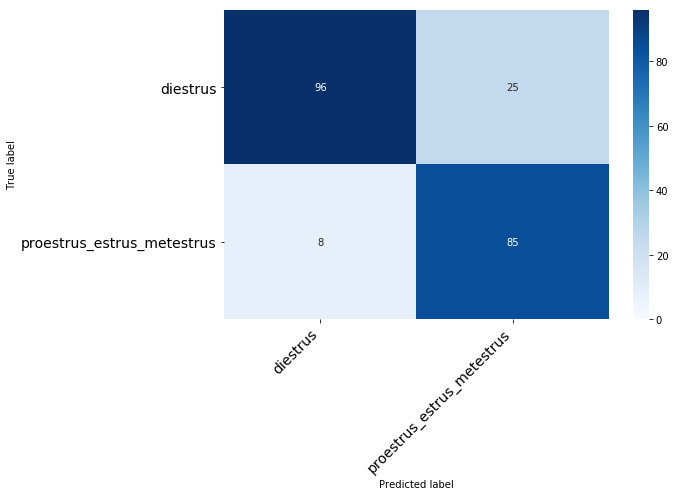

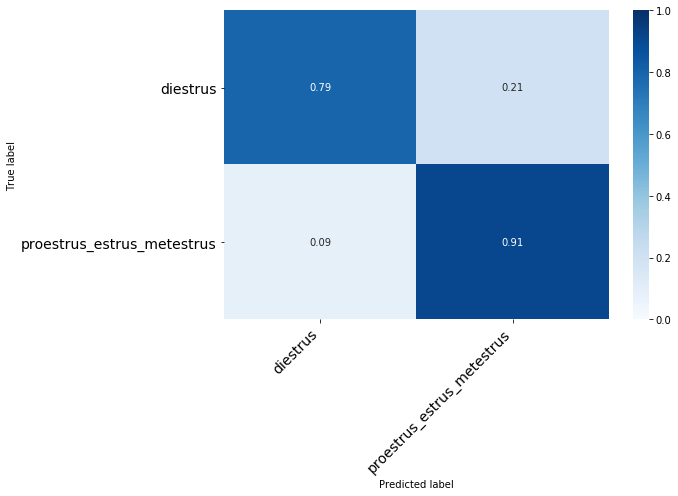

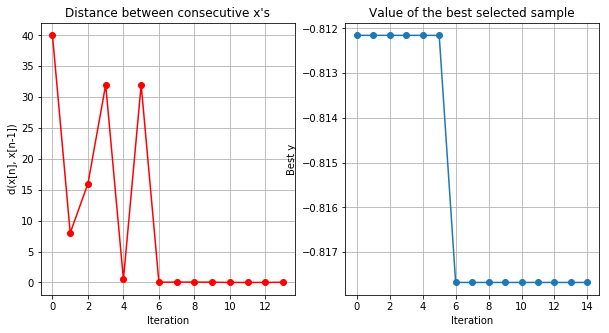

Best params: {'batch_size': 32.0, 'lr_decay': 0.2689977994454577, 'adam_lr': 0.032900208588493365, 'adam_beta1': 0.9313858324817013, 'adam_beta2': 0.9531971940989582, 'adam_wtdecay': 0.4249208280170039}
Iteration BEST, {'batch_size': 32.0, 'lr_decay': 0.2689977994454577, 'adam_lr': 0.032900208588493365, 'adam_beta1': 0.9313858324817013, 'adam_beta2': 0.9531971940989582, 'adam_wtdecay': 0.4249208280170039}


Epoch 45, Train, best val=0.8066:  94%|█████████▍| 960/1017 [00:15<00:00, 71.82images/s] 

In [ ]:
import gc # for manual garbage collection, reduce memory consumption

for chosen_model in MODELS:  # iterate over all models
    for chosen_optimizer in OPTIMIZERS: # iterate over all optimizers

        # iterate over both binary and quaternary datasets
        for data_dir in (
            os.path.join('data', 'die_vs_all_tt'), 
            os.path.join('data', '4_class_tt')
        ):
            print(utils.get_model_name(chosen_model), chosen_optimizer.__name__, data_dir)
            reset_globals(data_dir)  # reset some globals used for iteration tracking

            commit_message = f'Results for {data_dir} {utils.get_model_name(chosen_model)} {chosen_optimizer.__name__}.'
            try:
                # define and optimize the problem
                optimized = perform_bayesian_optimization()
                # plot the results
                plot_bo_results(optimized)
                # get and save the best trainable
                best_params = optimized.x_opt.flatten()
                print('Best params:', (params_to_meta_dict(best_params)))
                best_trainable = train(best_params, is_best=True)
                best_trainable.save(extra_meta=params_to_meta_dict(best_params))
                # evalute on the test set using the best model
                generate_test_metrics(best_trainable)
                commit_message += f' Best val: {best_trainable.best_val_accuracy:.4f}; Train: {best_trainable.associated_train_accuracy:.4f}'
                
            # if something bad happens, skip it so we can let the others run
            except Exception as e:
                print('Skipping because', e)
                _ = subprocess.check_call(["spd-say", "Uh-oh, something bad happened. "])
                _ = subprocess.check_call(["spd-say", f'{utils.get_model_name(chosen_model)}. {str(e).split()[:4]}.'])
                    
                import traceback  # DEBUG
                traceback.print_exc()
                commit_message += f' EXCEPTION {e}.'
    
            gc.collect()  # reduce memory usage

            # commit & push
            if PUSH_TO_GIT:
                push_to_git(commit_message)

# Final Commit and Push

In [ ]:
if PUSH_TO_GIT:
    import time
    time.sleep(120) # wait for two minutes to let everything render
    _ = subprocess.check_call(["spd-say", "Your code has finished running"])
    push_to_git("BO Final Commit")
    
print("Done")